In [2]:
pip install requests networkx


Note: you may need to restart the kernel to use updated packages.


# Bước 1: Chuẩn bị môi trường & API key

In [ ]:
import json
import pandas as pd
import re
import os
from pathlib import Path
import time
import hashlib
from itertools import islice
import requests
import networkx as nx
from dotenv import load_dotenv
import  random
from itertools import islice
import networkx as nx



In [3]:
# Load API key
load_dotenv()
API_KEY = os.getenv("STEAM_API_KEY")
if not API_KEY:
    raise SystemExit("Please set STEAM_API_KEY in environment or .env file")

BASE = "https://api.steampowered.com"
CACHE_DIR = Path("steam_cache")
CACHE_DIR.mkdir(exist_ok=True)

DELAY_BETWEEN_REQUESTS = 0.5
BATCH_SIZE = 50
MAX_ACHIEVEMENTS_APPS = 3
REQUEST_TIMEOUT = 15


# STEAM CRAWLER - full functions (cache, API, endpoints, BFS crawler, save outputs)
- Cache để tránh request trùng
- API request với backoff, skip private
- Các endpoint Steam: summaries, friends, owned games, recently played, groups, bans, achievements
- BFS crawl nhiều batch, skip user/private, merge cuối cùng
- Safe với NetworkX GEXF (loại bỏ NoneType)

In [6]:
# %% 
"""
STEAM CRAWLER - SAFE THROTTLED + CHECKPOINT
--------------------------------------------
- Cache tránh request trùng
- API request với backoff & throttle
- BFS crawl nhiều batch
- Lưu checkpoint mỗi N user
- In progress để theo dõi tiến trình
"""

# ================================
# Cache utils
# ================================
CACHE_DIR = Path("steam_cache")
CACHE_DIR.mkdir(exist_ok=True)

def cache_key(endpoint, params):
    s = endpoint + json.dumps(params, sort_keys=True)
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def cache_load(endpoint, params):
    k = cache_key(endpoint, params)
    p = CACHE_DIR / f"{k}.json"
    if p.exists():
        try:
            return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            return None
    return None

def cache_save(endpoint, params, data):
    k = cache_key(endpoint, params)
    p = CACHE_DIR / f"{k}.json"
    p.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")

# ================================
# Config crawl
# ================================
DELAY_MIN = 1.0
DELAY_MAX = 2.0
BATCH_SIZE = 50
MAX_APPS_PER_USER = 3
REQUEST_TIMEOUT = 15
CHECKPOINT_EVERY = 50
BASE = "https://api.steampowered.com"
API_KEY = os.getenv("STEAM_API_KEY")

# ================================
# API request with backoff & throttle
# ================================
def api_get(endpoint, params, use_cache=True):
    params = dict(params)
    params["key"] = API_KEY
    if use_cache:
        cached = cache_load(endpoint, params)
        if cached is not None:
            return cached

    url = f"{BASE}/{endpoint}"
    backoff = 1.0
    for attempt in range(6):
        try:
            r = requests.get(url, params=params, timeout=REQUEST_TIMEOUT)
            if r.status_code == 200:
                try: data = r.json()
                except ValueError: data = r.text
                cache_save(endpoint, params, data)
                time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))
                return data
            elif r.status_code in (429, 503):
                time.sleep(backoff + random.uniform(0.1,0.5))
                backoff *= 2
            elif r.status_code in (401,403):
                print(f"[PRIVATE] skip: {params}")
                return {"private": True}
            else:
                print(f"[WARN] {r.status_code} from {url} params={params}")
                return None
        except requests.RequestException as e:
            print(f"[WARN] Request exception {e}, backoff {backoff}s")
            time.sleep(backoff + random.uniform(0.1,0.5))
            backoff *= 2
    print("[ERROR] Max retries exceeded for", url)
    return None


# Helper chunks
def chunks(iterable, n):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, n))
        if not chunk: break
        yield chunk


# Steam endpoints
def get_player_summaries(steamid_list):
    endpoint="ISteamUser/GetPlayerSummaries/v0002/"; results=[]
    for batch in chunks(steamid_list,BATCH_SIZE):
        params={"steamids":",".join(batch)}
        data=api_get(endpoint,params)
        if data and not data.get("private"):
            results.extend(data.get("response",{}).get("players",[]))
    return results

def get_friend_list(steamid):
    endpoint="ISteamUser/GetFriendList/v0001/"
    params={"steamid":steamid,"relationship":"friend"}
    data=api_get(endpoint,params)
    if data and data.get("private"): return []
    return [f.get("steamid") for f in data.get("friendslist",{}).get("friends",[])] if data else []

def get_owned_games(steamid):
    endpoint="IPlayerService/GetOwnedGames/v0001/"
    params={"steamid":steamid,"include_appinfo":1,"include_played_free_games":1,"format":"json"}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("response",{}) if data else {}

def get_recently_played(steamid):
    endpoint="IPlayerService/GetRecentlyPlayedGames/v0001/"
    params={"steamid":steamid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("response",{}) if data else {}

def get_user_groups(steamid):
    endpoint="ISteamUser/GetUserGroupList/v1/"
    params={"steamid":steamid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return []
    return data.get("response",{}).get("groups",[]) if data else []

def get_player_bans(steamid_list):
    endpoint="ISteamUser/GetPlayerBans/v1/"; results=[]
    for batch in chunks(steamid_list,BATCH_SIZE):
        params={"steamids":",".join(batch)}
        data=api_get(endpoint,params)
        if data and not data.get("private"): results.extend(data.get("players",[]))
    return results

def get_player_achievements(steamid,appid):
    endpoint="ISteamUserStats/GetPlayerAchievements/v1/"
    params={"steamid":steamid,"appid":appid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("playerstats",{}) if data else {}

def resolve_vanity(name):
    endpoint="ISteamUser/ResolveVanityURL/v0001/"
    params={"vanityurl":name}
    data=api_get(endpoint,params)
    if data and data.get("response",{}).get("success")==1:
        return data["response"].get("steamid")
    return None

# ================================
# Load existing profiles
# ================================
def load_existing_profiles(json_path):
    if Path(json_path).exists():
        with open(json_path,"r",encoding="utf-8") as f:
            data=json.load(f)
        return set(data.keys()), data
    return set(), {}

# ================================
# Save outputs
# ================================
def save_outputs(G, profiles, out_prefix="steam_output"):
    # Clean node attributes
    for n, data in G.nodes(data=True):
        for k, v in list(data.items()):
            if v is None: data[k] = ""
            elif isinstance(v,(list,dict)): data[k]=str(v)
    json_path=f"{out_prefix}_profiles1.json"
    with open(json_path,"w",encoding="utf-8") as f: json.dump(profiles,f,indent=2,ensure_ascii=False)
    gexf_path=f"{out_prefix}_graph1.gexf"
    nx.write_gexf(G,gexf_path)
    print(f"[Saved] profiles -> {json_path}")
    print(f"[Saved] graph -> {gexf_path}")

# ================================
# BFS crawler with checkpoint
# ================================
def crawl(seed_ids, depth=1, max_users=1000, max_apps_per_user=3, visited_global=None, save_prefix="steam_output", fetch_achievements=True):
    G = nx.Graph()
    visited_global = visited_global or set()
    queue = [(s,0) for s in seed_ids]
    all_profiles = {}
    stats = {"public":0,"private":0,"skipped":0}

    while queue and len(visited_global)<max_users:
        steamid, d = queue.pop(0)
        if steamid in visited_global or d>depth: continue
        if not steamid.isdigit(): steamid=resolve_vanity(steamid) or steamid
        if not steamid.isdigit(): stats["skipped"]+=1; continue

        print(f"Crawling {steamid} (depth {d}) | Visited {len(visited_global)}/{max_users}")

        players = get_player_summaries([steamid])
        if not players:
            stats["private"]+=1
            visited_global.add(steamid)
            continue

        player = players[0]
        visited_global.add(steamid)
        stats["public"]+=1
        all_profiles[steamid] = player

        G.add_node(steamid,label=player.get("personaname",""),
                   avatar=player.get("avatarfull",""),
                   country=player.get("loccountrycode",""))

        friends = get_friend_list(steamid)
        for f in friends:
            G.add_edge(steamid,f)
            if f not in visited_global and d+1<=depth:
                queue.append((f,d+1))

        owned = get_owned_games(steamid)
        recent = get_recently_played(steamid)
        groups = get_user_groups(steamid)

        G.nodes[steamid]["owned_game_count"] = owned.get("game_count",0)
        G.nodes[steamid]["recent_count"] = recent.get("total_count",0)
        G.nodes[steamid]["groups"] = [g.get("groupid64") for g in groups] if groups else []

        apps = owned.get("games",[]) if isinstance(owned,dict) else []
        top_apps = sorted(apps, key=lambda x:x.get("playtime_forever",0), reverse=True)[:max_apps_per_user]
        G.nodes[steamid]["top_apps"] = [a.get("appid") for a in top_apps]

        # Achievements (optional, tốn thời gian)
        if fetch_achievements:
            achievements={}
            for app in top_apps: achievements[app.get("appid")] = get_player_achievements(steamid, app.get("appid"))
            G.nodes[steamid]["achievements_sample"] = achievements

        # Checkpoint every N users
        if len(visited_global) % CHECKPOINT_EVERY == 0:
            save_outputs(G, all_profiles, out_prefix=f"{save_prefix}_partial")
            print(f"[Checkpoint] Saved after {len(visited_global)} users")

    # Final bans
    bans = get_player_bans(list(visited_global))
    bans_map = {b["SteamId"]:b for b in bans}
    for node in G.nodes:
        G.nodes[node]["ban_info"] = bans_map.get(node,{})

    save_outputs(G, all_profiles, out_prefix=save_prefix)
    print(f"Stats: {stats}")
    return G, all_profiles, visited_global

# ================================
# Example run
# ================================
visited_prev, profiles_prev = load_existing_profiles("steam_output_test_profiles1.json")
SEEDS = ["76561198294300457","76561197973974836"]  # Thay bằng steamid của bạn

G_new, profiles_new, visited_new = crawl(
    SEEDS,
    depth=2,
    max_users=5000,
    max_apps_per_user=3,
    visited_global=visited_prev,
    save_prefix="steam_output",
    fetch_achievements=False  # Test nhanh trước
)


Crawling 76561198294300457 (depth 0) | Visited 0/5000
Crawling 76561197973974836 (depth 0) | Visited 1/5000
Crawling 76561197993609350 (depth 1) | Visited 2/5000
Crawling 76561198046562139 (depth 1) | Visited 3/5000
Crawling 76561198061953477 (depth 1) | Visited 4/5000
Crawling 76561198062226249 (depth 1) | Visited 5/5000
Crawling 76561198076766555 (depth 1) | Visited 6/5000
Crawling 76561198077186687 (depth 1) | Visited 7/5000
Crawling 76561198097199951 (depth 1) | Visited 8/5000
Crawling 76561198109776027 (depth 1) | Visited 9/5000
Crawling 76561198110181817 (depth 1) | Visited 10/5000
Crawling 76561198116685130 (depth 1) | Visited 11/5000
Crawling 76561198120611517 (depth 1) | Visited 12/5000
Crawling 76561198128339070 (depth 1) | Visited 13/5000
Crawling 76561198134815732 (depth 1) | Visited 14/5000
Crawling 76561198135035013 (depth 1) | Visited 15/5000
Crawling 76561198138224835 (depth 1) | Visited 16/5000
[PRIVATE] skip: {'steamid': '76561198138224835', 'relationship': 'friend', 

KeyboardInterrupt: 

# Phân loại category cho steam_cache (game, group, friends, recently_played, summaries, bans, achievements, vanity, others)

In [4]:
import os
import json

def merge_json_files(input_dir, output_file):

    merged_data = {}

    for filename in os.listdir(input_dir):
        if filename.endswith(".json"):
            file_path = os.path.join(input_dir, filename)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)

                    # Nếu dữ liệu có steamid thì dùng làm key
                    steamid = data.get("steamid") or data.get("id") or filename
                    merged_data[steamid] = data

            except json.JSONDecodeError:
                print(f" Lỗi đọc JSON: {file_path}, bỏ qua...")
            except Exception as e:
                print(f" Lỗi khác với file {file_path}: {e}")

    # Lưu lại thành 1 file JSON duy nhất
    with open(output_file, "w", encoding="utf-8") as out:
        json.dump(merged_data, out, ensure_ascii=False, indent=2)

    print(f" Đã gộp {len(merged_data)} file từ {input_dir} vào {output_file}")

merge_json_files("steam_cache/games", "merged_games.json")
merge_json_files("steam_cache/summaries", "merged_summaries.json")
merge_json_files("steam_cache/achievements", "merged_achievements.json")
merge_json_files("steam_cache/friends", "merged_friends.json")
merge_json_files("steam_cache/groups", "merged_groups.json")


✅ Đã gộp 1502 file từ steam_cache/games vào merged_games.json
✅ Đã gộp 1951 file từ steam_cache/summaries vào merged_summaries.json
✅ Đã gộp 491 file từ steam_cache/achievements vào merged_achievements.json
✅ Đã gộp 1583 file từ steam_cache/friends vào merged_friends.json
✅ Đã gộp 1800 file từ steam_cache/groups vào merged_groups.json


# CLEAN DATA


## Chuyển các file json thành các file csv, xử lý dấu, ký tự, icon trong tên người dùng

tách file games.json


In [25]:
import json
import pandas as pd

# ---- 1. Đọc file JSON gốc ----
with open("steam_cache/steam_cache_json/games.json", "r", encoding="utf-8") as f:  # thay đường dẫn vào đây
    data = json.load(f)

rows = []

# ---- 2. Duyệt qua từng user (key = sha1_id) ----
for sha1_id, content in data.items():
    resp = content.get("response", {})
    games = resp.get("games", [])
    
    for g in games:
        rows.append({
            "sha1_id": sha1_id,
            "appid": g.get("appid"),
            "name": g.get("name"),
            "playtime_forever": g.get("playtime_forever"),
            "playtime_2weeks": g.get("playtime_2weeks"),
            "img_icon_url": g.get("img_icon_url"),
            "content_descriptorids": ",".join(map(str, g.get("content_descriptorids", [])))
        })

# ---- 3. Chuyển sang DataFrame ----
df = pd.DataFrame(rows)

# ---- 4. Xuất ra CSV ----
df.to_csv("games_flat.csv", index=False, encoding="utf-8-sig")

print(f"✅ Đã lưu {len(df)} dòng vào games_flat.csv")


✅ Đã lưu 231102 dòng vào games_flat.csv


In [12]:


# 1. Đọc JSON VÀ TRÍCH XUẤT DANH SÁCH PROFILES (Đã sửa)
with open("steam_cache/profiles_users.json", "r", encoding="utf-8") as f:
    data = json.load(f)

if isinstance(data, dict):
    profiles_list = list(data.values())
else:
    profiles_list = data

# Tạo DataFrame từ danh sách 
df = pd.DataFrame(profiles_list)

# 2. Xử lý cột tên người dùng
def clean_name(name):
    if not isinstance(name, str):
        return ""
    
    # Loại bỏký tự không phải chữ/số/space/tiếng Việt
    name = re.sub(r"[^a-zA-Z0-9À-ỹ\s]", "", name)

    # Xóa khoảng trắng đầu/cuối và gộp khoảng trắng liên tiếp
    name = re.sub(r"\s+", " ", name).strip()
    
    return name
if 'personaname' in df.columns:
    df['personaname'] = df['personaname'].apply(clean_name)
    print("Xử lý xong.")
else:
    print(" Cột lo tồn tại.")

# 3. Lưu ra CSV với UTF-8 để giữ dấu tiengs viẹte
df.to_csv("steam_cache/profiles_users.csv", index=False, encoding="utf-8-sig")
print("Dữ liệu đã được lưu")

Xử lý cột 'personaname' hoàn tất.
Dữ liệu đã được lưu vào steam_cache/profiles_users.csv.


Tìm dữ liệu thiếu


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bước 1: Đọc file
df = pd.read_csv('steam_cache/profiles_users.csv')  # 

# Bước 2: Xem cấu trúc dữ liệu
print("Thông tin dataset:")
print(df.info())
print("\n5 dòng đầu tiên:")
print(df.head())

# Bước 3: Kiểm tra giá trị thiếu
print("\nGiá trị thiếu trong từng cột:")
print(df.isnull().sum())



Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   steamid                   1949 non-null   float64
 1   communityvisibilitystate  1949 non-null   float64
 2   profilestate              1949 non-null   float64
 3   personaname               1875 non-null   object 
 4   commentpermission         1380 non-null   float64
 5   profileurl                1949 non-null   object 
 6   avatarfull                1949 non-null   object 
 7   personastate              1949 non-null   float64
 8   realname                  938 non-null    object 
 9   primaryclanid             1800 non-null   float64
 10  timecreated               1800 non-null   float64
 11  personastateflags         1800 non-null   float64
 12  loccountrycode            1371 non-null   object 
 13  locstatecode              850 non-null    ob

In [6]:

# Loại bỏ các dòng ko có userid 
df_clean = df.dropna(subset=['steamid']).copy()

# 2. XỬ LÝ CÁC CỘT CÓ GIÁ TRỊ THIẾU QUAN TRỌNG
# Điền giá trị mặc định
df_clean['commentpermission'].fillna(0, inplace=True)

# Xóa các cột ( không quan trọng, thiếu nhiều)
df_clean = df_clean.drop(['loccityid', 'gameextrainfo', 'gameid', 'lobbysteamid', 'gameserverip', 'gameserversteamid'], axis=1)



C:\Users\Loc\AppData\Local\Temp\ipykernel_8272\3346910078.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['commentpermission'].fillna(0, inplace=True)


=== LÀM SẠCH DỮ LIỆU ===
Tổng số dòng ban đầu: 3900
Số dòng sau khi loại bỏ dòng trống: 1949

=== XỬ LÝ TIMECREATED ===
Dòng có timecreated: 1800
Dòng không có timecreated: 149

PHÂN TÍCH TỔNG QUAN - 1949 USER STEAM
📊 THỐNG KÊ PROFILE:
• Profile công khai: 1800/1949 (92.4%)
• Có tên thật: 938/1949 (48.1%)
• Có quốc gia: 1371/1949 (70.3%)
• Có timecreated: 1800/1949 (92.4%)

PHÂN TÍCH ĐỊA LÝ NGƯỜI DÙNG
🏴‍☠️ TOP 10 QUỐC GIA:
  VN: 640 users (46.7%)
  US: 111 users (8.1%)
  JP: 51 users (3.7%)
  GB: 46 users (3.4%)
  DE: 43 users (3.1%)
  RU: 34 users (2.5%)
  FR: 32 users (2.3%)
  CA: 29 users (2.1%)
  CN: 23 users (1.7%)
  KR: 22 users (1.6%)


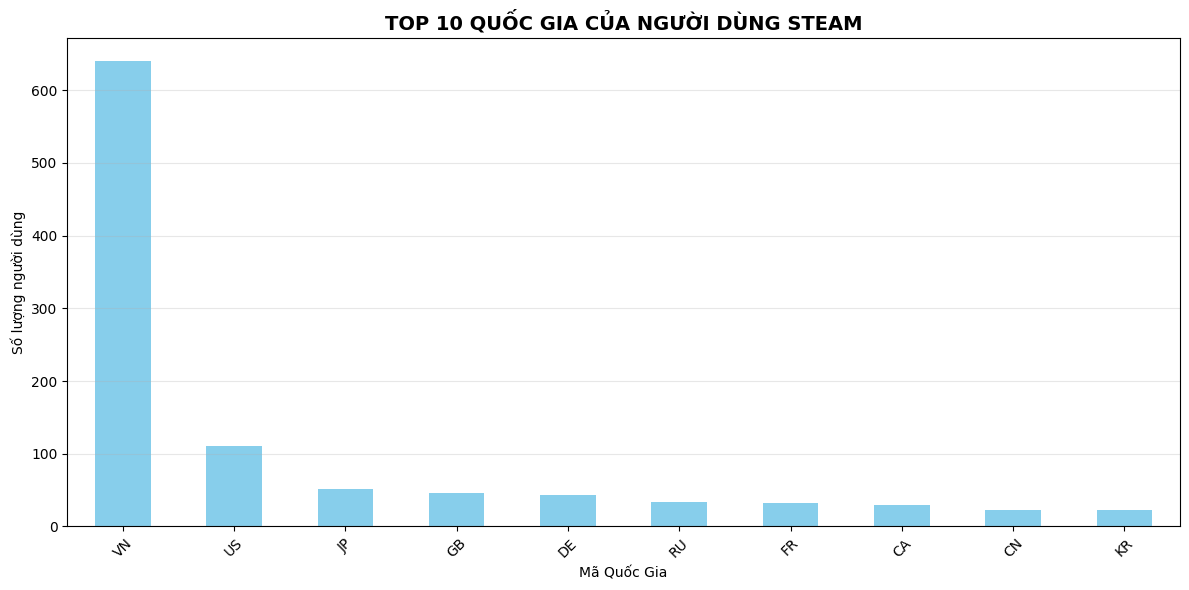


PHÂN TÍCH TUỔI TÀI KHOẢN (1800 USER CÓ DỮ LIỆU)
 SỐ TÀI KHOẢN ĐƯỢC TẠO THEO NĂM:
  2003: 6 tài khoản
  2004: 19 tài khoản
  2005: 10 tài khoản
  2006: 4 tài khoản
  2007: 16 tài khoản
  2008: 23 tài khoản
  2009: 31 tài khoản
  2010: 48 tài khoản
  2011: 109 tài khoản
  2012: 174 tài khoản
  2013: 273 tài khoản
  2014: 353 tài khoản
  2015: 278 tài khoản
  2016: 202 tài khoản
  2017: 114 tài khoản
  2018: 60 tài khoản
  2019: 23 tài khoản
  2020: 23 tài khoản
  2021: 17 tài khoản
  2022: 12 tài khoản
  2023: 5 tài khoản

 THỐNG KÊ TUỔI TÀI KHOẢN:
  • Tuổi trung bình: 4128 ngày (~11.3 năm)
  • Tuổi trung vị: 4104 ngày
  • Tài khoản cũ nhất: 8050 ngày (~22.1 năm)
  • Tài khoản mới nhất: 730 ngày (~2.0 năm)


C:\Users\Loc\AppData\Local\Temp\ipykernel_8272\3214833205.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_timecreated['year_created'] = users_with_timecreated['account_created'].dt.year


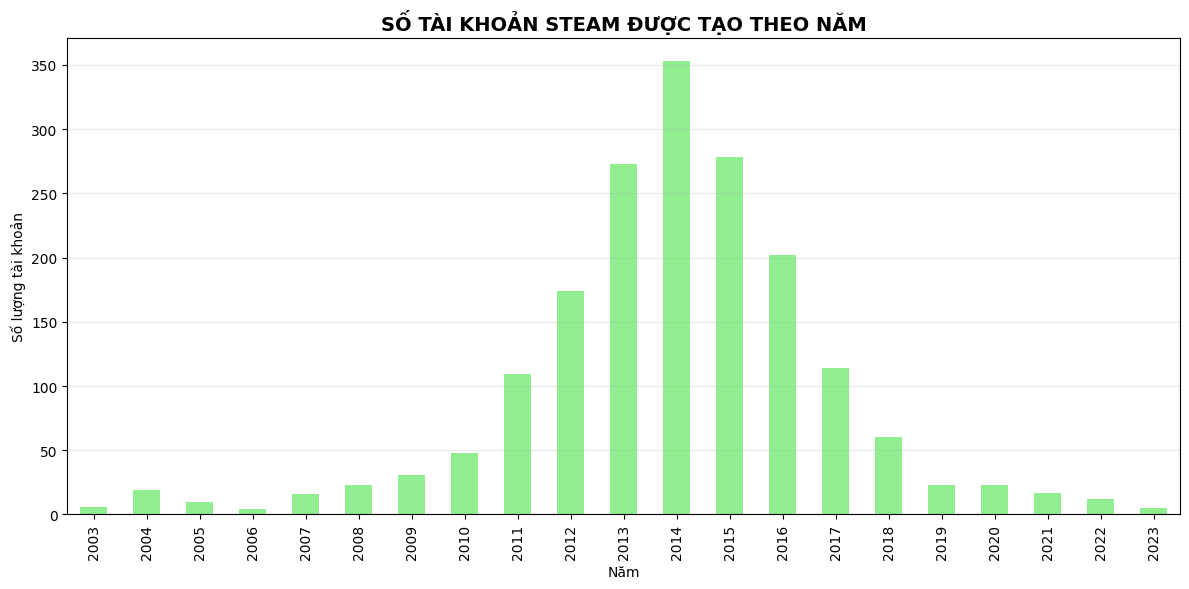

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime



# 1. LÀM SẠCH DỮ LIỆU - CHỈ GIỮ LẠI DÒNG CÓ STEAMID
print("=== LÀM SẠCH DỮ LIỆU ===")
print(f"Tổng số dòng ban đầu: {len(df)}")

df_clean = df.dropna(subset=['steamid']).copy()
print(f"Số dòng sau khi loại bỏ dòng trống: {len(df_clean)}")

# 2. XỬ LÝ TIMECREATED - TÁCH THÀNH 2 NHÓM
print(f"\n=== XỬ LÝ TIMECREATED ===")
print(f"Dòng có timecreated: {df_clean['timecreated'].notna().sum()}")
print(f"Dòng không có timecreated: {df_clean['timecreated'].isna().sum()}")

# Tạo cột datetime chỉ cho dòng có timecreated
df_clean['account_created'] = pd.to_datetime(df_clean['timecreated'], unit='s', errors='coerce')
df_clean['account_age_days'] = (datetime.now() - df_clean['account_created']).dt.days

# 3. PHÂN TÍCH TỔNG QUAN
print("\n" + "="*60)
print("PHÂN TÍCH TỔNG QUAN - 1949 USER STEAM")
print("="*60)

# Thống kê cơ bản
public_profiles = (df_clean['communityvisibilitystate'] == 3).sum()
has_realname = df_clean['realname'].notna().sum()
has_country = df_clean['loccountrycode'].notna().sum()

print(f"📊 THỐNG KÊ PROFILE:")
print(f"• Profile công khai: {public_profiles}/{len(df_clean)} ({public_profiles/len(df_clean)*100:.1f}%)")
print(f"• Có tên thật: {has_realname}/{len(df_clean)} ({has_realname/len(df_clean)*100:.1f}%)")
print(f"• Có quốc gia: {has_country}/{len(df_clean)} ({has_country/len(df_clean)*100:.1f}%)")
print(f"• Có timecreated: {df_clean['timecreated'].notna().sum()}/{len(df_clean)} ({(df_clean['timecreated'].notna().sum()/len(df_clean))*100:.1f}%)")

# 4. PHÂN TÍCH ĐỊA LÝ
print("\n" + "="*60)
print("PHÂN TÍCH ĐỊA LÝ NGƯỜI DÙNG")
print("="*60)

if has_country > 0:
    country_stats = df_clean['loccountrycode'].value_counts().head(10)
    print("🏴‍☠️ TOP 10 QUỐC GIA:")
    for country, count in country_stats.items():
        percentage = (count / has_country) * 100
        print(f"  {country}: {count} users ({percentage:.1f}%)")
    
    # Biểu đồ quốc gia
    plt.figure(figsize=(12, 6))
    country_stats.head(10).plot(kind='bar', color='skyblue')
    plt.title('TOP 10 QUỐC GIA CỦA NGƯỜI DÙNG STEAM', fontsize=14, fontweight='bold')
    plt.xlabel('Mã Quốc Gia')
    plt.ylabel('Số lượng người dùng')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(" Không có dữ liệu quốc gia để phân tích")

# 5. PHÂN TÍCH THỜI GIAN (CHỈ CHO USER CÓ TIMECREATED)
print("\n" + "="*60)
print("PHÂN TÍCH TUỔI TÀI KHOẢN (1800 USER CÓ DỮ LIỆU)")
print("="*60)

users_with_timecreated = df_clean[df_clean['timecreated'].notna()]

if len(users_with_timecreated) > 0:
    # Phân bố theo năm
    users_with_timecreated['year_created'] = users_with_timecreated['account_created'].dt.year
    yearly_creation = users_with_timecreated['year_created'].value_counts().sort_index()
    
    print(" SỐ TÀI KHOẢN ĐƯỢC TẠO THEO NĂM:")
    for year, count in yearly_creation.items():
        print(f"  {year}: {count} tài khoản")
    
    # Thống kê tuổi tài khoản
    print(f"\n THỐNG KÊ TUỔI TÀI KHOẢN:")
    print(f"  • Tuổi trung bình: {users_with_timecreated['account_age_days'].mean():.0f} ngày (~{users_with_timecreated['account_age_days'].mean()/365:.1f} năm)")
    print(f"  • Tuổi trung vị: {users_with_timecreated['account_age_days'].median():.0f} ngày")
    print(f"  • Tài khoản cũ nhất: {users_with_timecreated['account_age_days'].max():.0f} ngày (~{users_with_timecreated['account_age_days'].max()/365:.1f} năm)")
    print(f"  • Tài khoản mới nhất: {users_with_timecreated['account_age_days'].min():.0f} ngày (~{users_with_timecreated['account_age_days'].min()/365:.1f} năm)")
    
    # Biểu đồ năm tạo tài khoản
    plt.figure(figsize=(12, 6))
    yearly_creation.plot(kind='bar', color='lightgreen')
    plt.title('SỐ TÀI KHOẢN STEAM ĐƯỢC TẠO THEO NĂM', fontsize=14, fontweight='bold')
    plt.xlabel('Năm')
    plt.ylabel('Số lượng tài khoản')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ phân bố tuổi tài kho

In [ ]:
# 3. PHÂN TÍKH KHÁM PHÁ (EDA) - TRẢ LỜI CÂU HỎI CƠ BẢN

print("\n" + "="*50)
print("PHÂN TÍCH TỔNG QUAN")
print("="*50)

# Tỷ lệ profile công khai
public_profiles = (df_clean['communityvisibilitystate'] == 3).sum()
print(f"Số profile công khai (visibility=3): {public_profiles}/{len(df_clean)} ({public_profiles/len(df_clean)*100:.1f}%)")

# Tỷ lệ có tên thật
has_realname = df_clean['realname'].notna().sum()
print(f"Số user công khai tên thật: {has_realname}/{len(df_clean)} ({has_realname/len(df_clean)*100:.1f}%)")

# Phân bố trạng thái online
print("\nPHÂN BỐ TRẠNG THÁI ONLINE:")
print(df_clean['personastate'].value_counts())

# 4. PHÂN TÍCH ĐỊA LÝ
print("\n" + "="*50)
print("PHÂN TÍCH ĐỊA LÝ")
print("="*50)

# Top 10 quốc gia
country_stats = df_clean['loccountrycode'].value_counts().head(10)
print("Top 10 quốc gia:")
print(country_stats)

# Vẽ biểu đồ phân bố quốc gia
plt.figure(figsize=(12, 6))
country_stats.head(10).plot(kind='bar')
plt.title('Top 10 Quốc Gia Của Người Dùng Steam')
plt.xlabel('Mã Quốc Gia')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. PHÂN TÍCH THỜI GIAN TẠO TÀI KHOẢN
print("\n" + "="*50)
print("PHÂN TÍCH TUỔI TÀI KHOẢN")
print("="*50)

# Phân bố theo năm tạo tài khoản
df_clean['year_created'] = df_clean['timecreated'].dt.year
yearly_creation = df_clean['year_created'].value_counts().sort_index()

print("Số tài khoản được tạo theo năm:")
print(yearly_creation)

# Vẽ biểu đồ năm tạo tài khoản
plt.figure(figsize=(12, 6))
yearly_creation.plot(kind='bar')
plt.title('Số Tài Khoản Steam Được Tạo Theo Năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng tài khoản')
plt.tight_layout()
plt.show()

# 6. THỐNG KÊ MÔ TẢ VỀ TUỔI TÀI KHOẢN
print("\nTHỐNG KÊ TUỔI TÀI KHOẢN (ngày):")
print(f"Tuổi trung bình: {df_clean['account_age_days'].mean():.0f} ngày")
print(f"Tuổi trung vị: {df_clean['account_age_days'].median():.0f} ngày")
print(f"Tài khoản cũ nhất: {df_clean['account_age_days'].max():.0f} ngày (~{df_clean['account_age_days'].max()/365:.1f} năm)")
print(f"Tài khoản mới nhất: {df_clean['account_age_days'].min():.0f} ngày")

# 7. KIỂM TRA MỐI QUAN HỆ GIỮA CÁC BIẾN
print("\n" + "="*50)
print("MỐI QUAN HỆ GIỮA TUỔI TÀI KHOẢN VÀ THÔNG TIN CÔNG KHAI")
print("="*50)

# So sánh tuổi tài khoản giữa người có và không có thông tin địa lý
has_country = df_clean[df_clean['loccountrycode'].notna()]['account_age_days']
no_country = df_clean[df_clean['loccountrycode'].isna()]['account_age_days']

print(f"Tuổi TB tài khoản (có quốc gia): {has_country.mean():.0f} ngày")
print(f"Tuổi TB tài khoản (không quốc gia): {no_country.mean():.0f} ngày")

# Hiển thị thông tin cuối cùng về dataset
print("\n" + "="*50)
print("THÔNG TIN DATASET SAU KHI LÀM SẠCH")
print("="*50)
print(df_clean.info())